# Resonance Finding Example: Rum Rhum Deployment

This notebook:

1) Downloads and removes instrument response for some publicly available OBS data from the Rum Rhum deployment with ObsPy. 
2) Computes 15 minute spectrograms using the same setup during training.
3) Runs these spectrograms through the trained resonance finding ML model.
4) Provides some plotting utilities to explore the resulting resonance masks. 

In [7]:
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
from pathlib import Path
import joblib
import datetime 
import re
import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from reverb.utils.spectrograms import SpectrogramCalculator

# utility function for parallelising function calls
NUM_JOBS = 10
parallel_execution = lambda input_list, function: joblib.Parallel(n_jobs=NUM_JOBS)(joblib.delayed(function)(*args) for args in input_list)

### Spectrogram Processing

Here we specify the spectrogram processing configuration used during training. These should only be changed with care, as the model performance may deterioriate with different data preprocessing.

In [8]:
config = dict(
    # trace processing parameters
    trace_prefilter = [1./200, 1./150, 35, 45],
    trace_unit = 'DISP',
    trace_waterlevel = 300.,
    trace_resample = True,
    trace_resampling_rate = 100,
    trace_taper = [0.05, True],

    # spectrogram parameters
    downsample_dims = (400,60),
    duration = 15, # key parameter, in minutes
    window_length = 50,
    overlap = 0.75,
    
)

out_dir = Path('specs/RR_whales')
out_dir.mkdir(exist_ok=True, parents=True)

specs = SpectrogramCalculator(config)

Download data from the RR45 OBS in the Rum Rhum deployment. You can vary the number of days downloaded for faster processing times.

The main computational bottleneck in this notebook is the response removal step. 

In [9]:
# STEP 1 - downloading and processing with ObsPy
stations = ['RR41', 'RR42', 'RR43', 'RR44', 'RR45', 'RR46', 'RR47', 'RR48',]

client = Client("RESIF")

def download_and_process_data(network, station, location, channel, start, end):
    st = client.get_waveforms(network, station, location, channel, starttime=start, endtime=end)
    st = st.merge()
    resp = client.get_stations(
        network=network, sta=station, loc=location, channel=channel,
        level="response")
    st = specs.remove_response(st[0], resp)

    return st


Now we compute our 15 minute spectrograms and save them in an output directory

In [7]:
# STEP 2 - generating 15 min spectrograms 
def build_datetime_list(start, end, duration):
    current = start
    while current + duration * 60 < end:
        new_time = current + duration * 60
        yield current, new_time
        current = new_time

# list of spectrogram start and end times we'd like to compute

num_days = 1
start = UTCDateTime("2013-05-31T00:00:00.000")
end = start + num_days * 24 * 60 * 60
# stations = ['RR41', 'RR42', 'RR43', 'RR44', 'RR45', 'RR46', 'RR47', 'RR48',]

for station in stations:
    try:
        st = download_and_process_data("YV", station, "00", "BHZ", start, end)
    except:
        continue

    datetimes = list(build_datetime_list(start, end, config['duration']))

    from functools import partial
    compute_and_save_callable = partial(specs.compute_and_save, st, out_dir)
    _ = parallel_execution(datetimes, compute_and_save_callable)

Here we use some utilities and wrappers from the iReverb package to run inference over our precomputed spectrograms

In [10]:
# STEP 3 - preparing and running ML model

from reverb.training.dataloaders import RawDataDataset
from reverb.analysis.inference import ML_Model_Inference, MaskGenerator, SimpleNameImageDataset, WhaleFinder

path_to_model = '../data/whale_finder.pl_ckpt'
model = ML_Model_Inference(path_to_model, device = 'cuda')

h5_files = list(out_dir.glob('*.h5'))
image_dataset = SimpleNameImageDataset(h5_files, padding=(0, 4, 0, 17))
mask_generator = MaskGenerator(model, image_dataset, batch_size=200)

whale_finder = WhaleFinder(model, image_dataset, batch_size=200)

whale_call_bands = [[26,28]]
spec_frequencies = np.linspace(1.01,50.01, 399)
whale_frequencies_mask = np.zeros(399, dtype='int64')
for band in whale_call_bands:
    start, end = band
    mask_indices = np.where((spec_frequencies >= start) & (spec_frequencies <= end))
    whale_frequencies_mask[mask_indices] = 1

# masks for each input spectrogram are saved in an output folder 
whale_finding_folder = 'results/RR_whales/certain_whales'

RERUN_LABELLING = False

if RERUN_LABELLING:
    whale_finder.find_and_save_whale_calls(
        whale_finding_folder, whale_frequencies_mask[::-1], threshold=40
    )


We provide some simple utilities to extract the spectrogram and mask information together. This is just an example for basic plotting purposes.

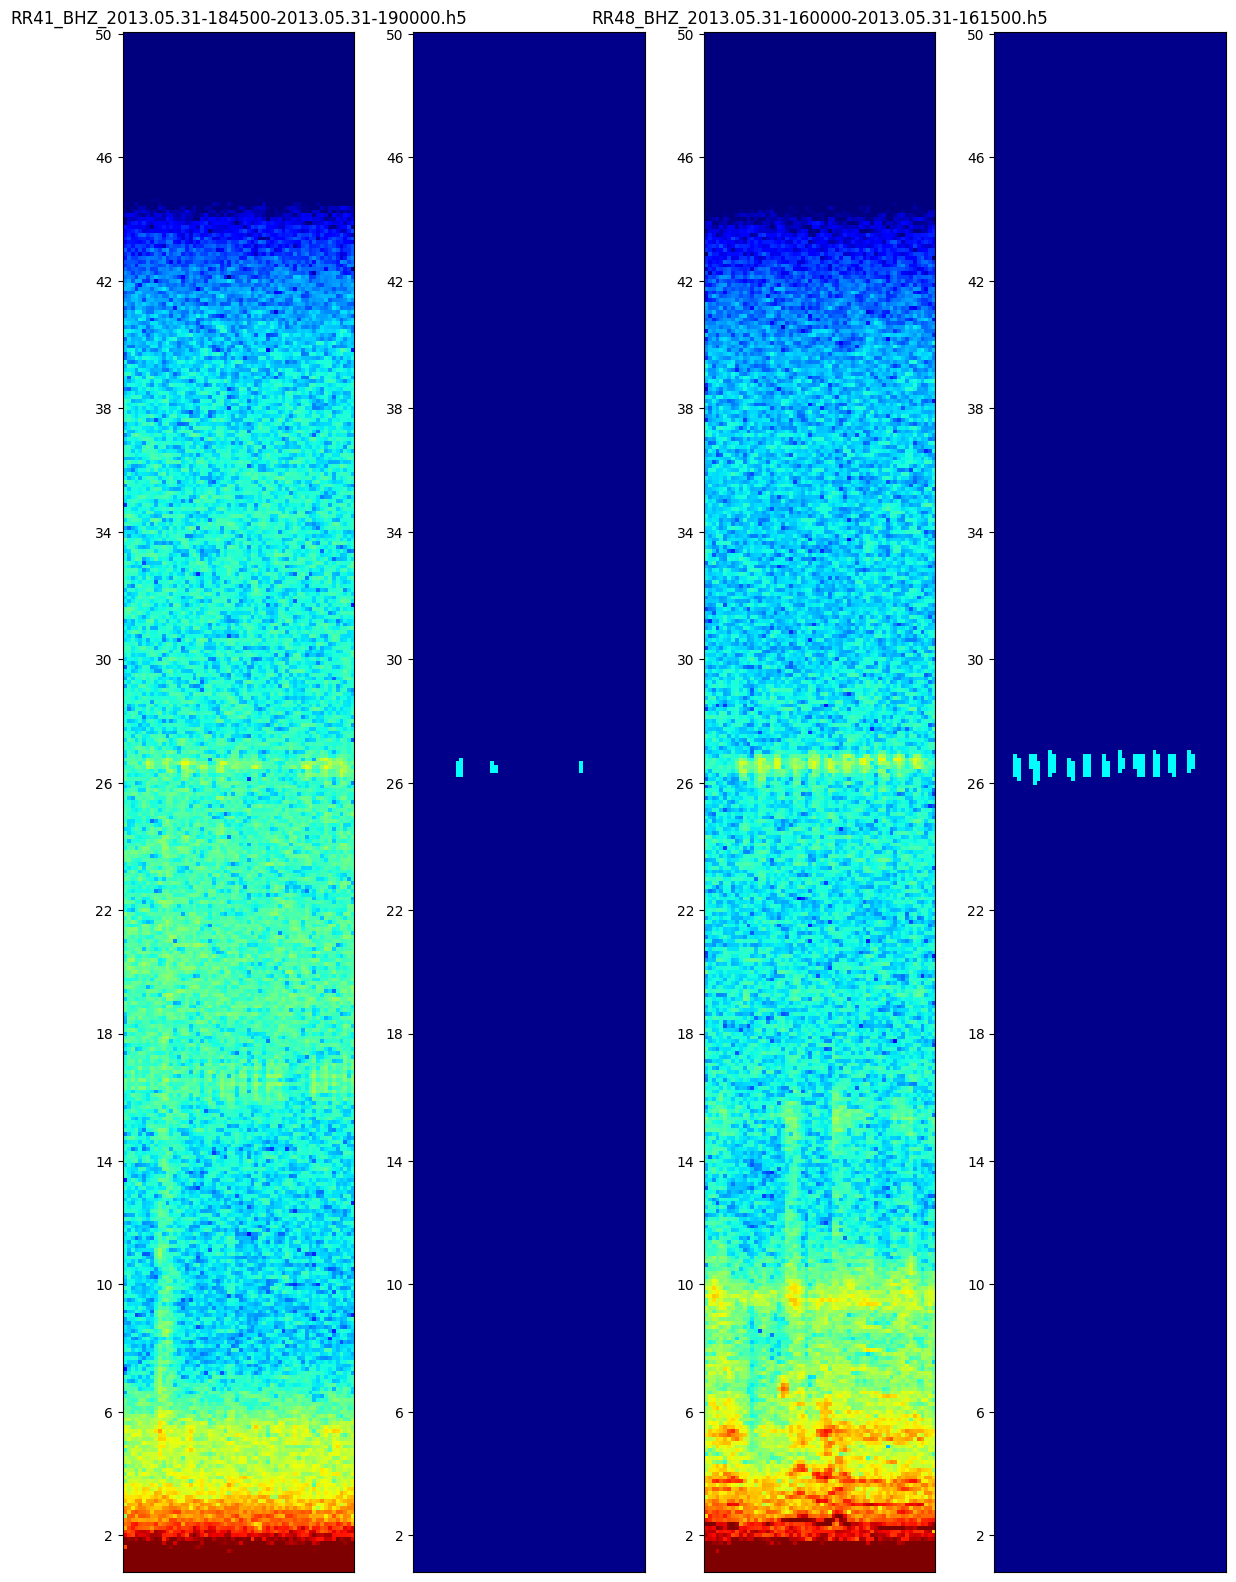

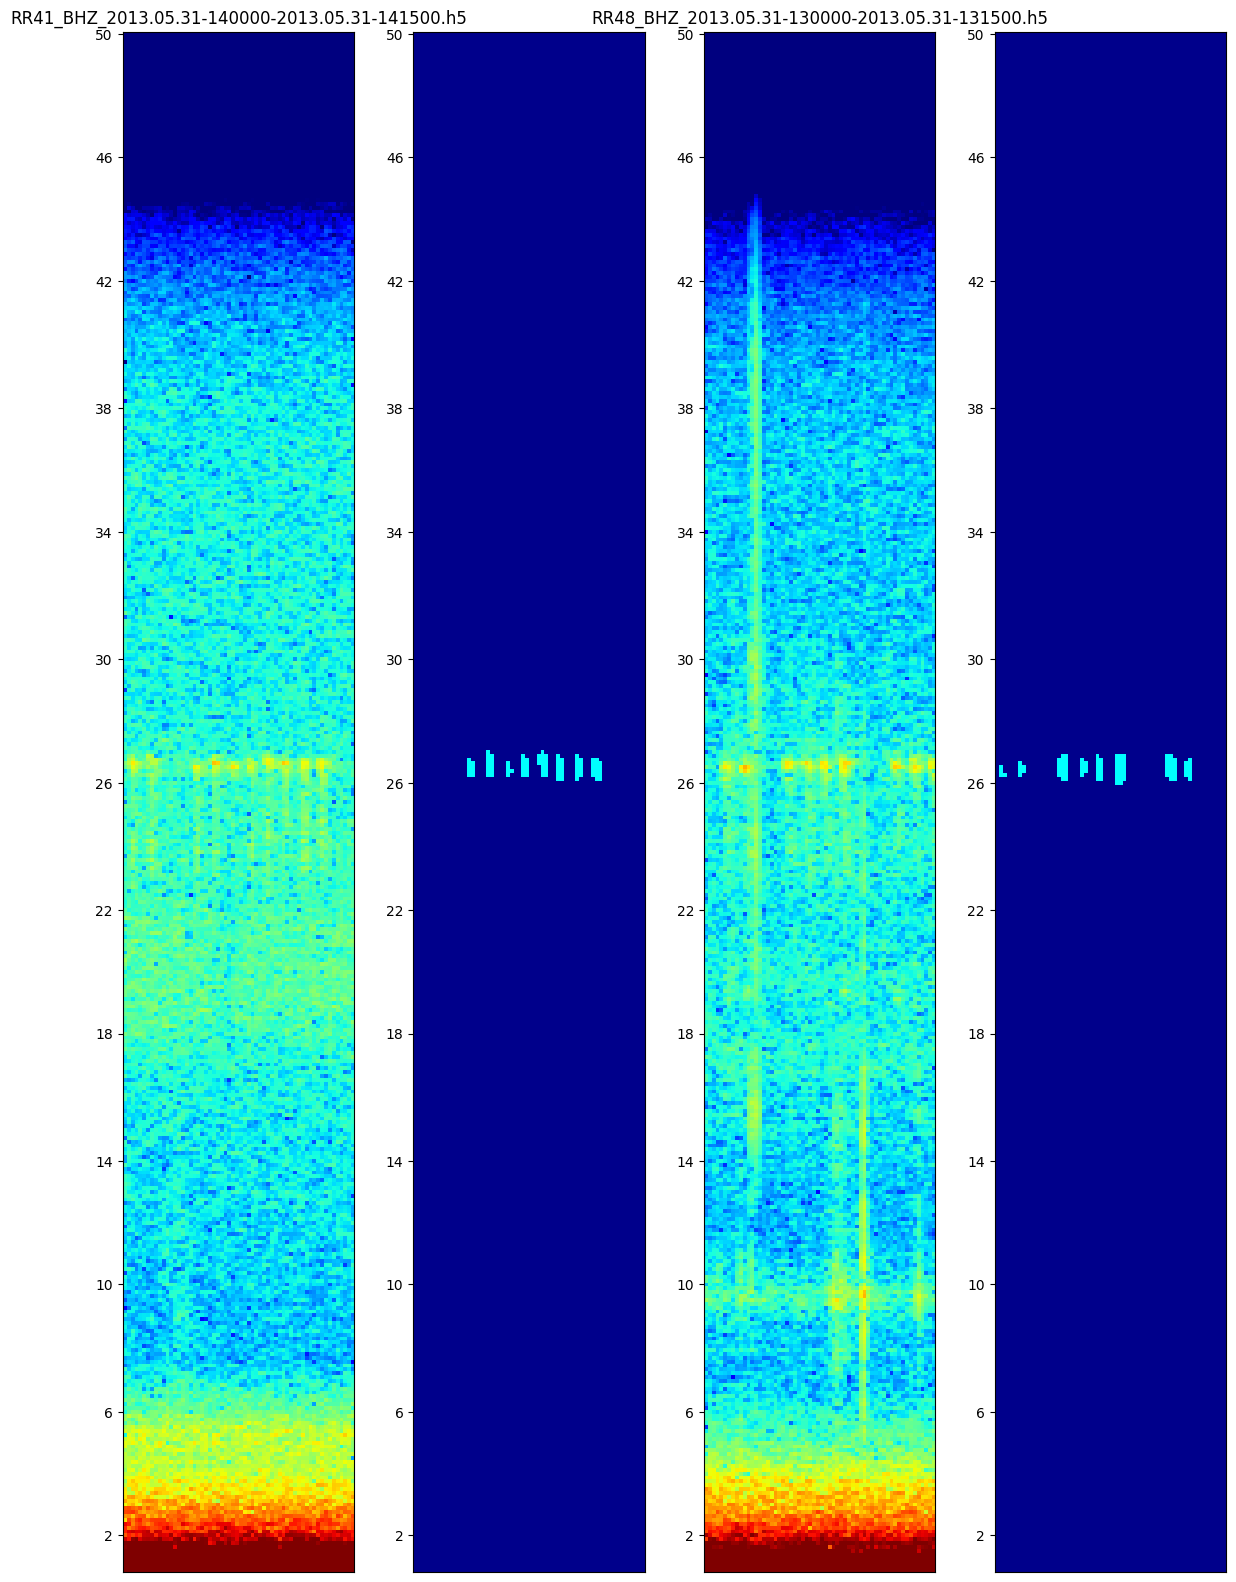

In [11]:
import h5py

def load_whale_mask(file):
    with h5py.File(file, 'r') as f:
        return np.array(f['mask'])

def pairwise(iterable):
    "s -> (s0, s1), (s2, s3), (s4, s5), ..."
    a = iter(iterable)
    return zip(a, a)

import matplotlib.pyplot as plt
from reverb.analysis.plotting import get_spectrogram_colors
found_whales = Path(whale_finding_folder).glob('*.h5')
found_whales = list(found_whales)

colors = ['darkblue','cyan']
custom_map = plt.cm.colors.ListedColormap(colors)
spec_frequencies = np.linspace(1.01,50.0, 399)
# plot spectrogram alongside mask
num_plots = 5
for file_pair in pairwise(found_whales[:num_plots]):
    fig, axes = plt.subplots(1, 4, figsize=(15, 20))
    
    for i, file in enumerate(file_pair):
        data_filepath = out_dir / file.name
        img = RawDataDataset.load_image(data_filepath, pad=(0,0,0,0))
        mask = load_whale_mask(file)
        # number of non-zero pixels in mask
        axes[2*i].imshow(get_spectrogram_colors(img[0]))
        axes[2*i + 1].imshow(mask, custom_map)
        axes[2*i].set_title(file.name)

        indices = np.linspace(0, 398, 50, dtype='int64')
        for ax in axes.flat:
            ax.set_xticks([])
            ax.set_xticklabels([])
            ax.set_yticks(indices[::4])
            ax.set_yticklabels(list(map(round,spec_frequencies[indices[::-1][::4]])))
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()
    

In [12]:
import numpy as np
import scipy.ndimage as ndi
import datetime
import os

def extract_whale_calls(file_name, mask, min_size=5):
    # Get start and end timestamps from the file name
    base_name = Path(file_name).name
    parts = base_name.split('_')
    times_string = parts[2]

    start_time_str = times_string.split('-')[0] + '-' + times_string.split('-')[1]
    end_time_str = times_string.split('-')[2] + '-' + times_string.split('-')[3].replace('.h5', '')

    start_time = datetime.datetime.strptime(start_time_str, '%Y.%m.%d-%H%M%S')
    end_time = datetime.datetime.strptime(end_time_str, '%Y.%m.%d-%H%M%S')

    duration = (end_time - start_time).total_seconds()
    labeled, num_features = ndi.label(mask)
    # Store detected whale calls
    whale_calls = []

    for region_idx in range(1, num_features + 1):
        region = np.argwhere(labeled == region_idx)
        
        # Filter out small regions
        if len(region) < min_size:
            continue
        mean_x = np.mean(region[:, 1])

        # Normalize the x-coordinate to a fraction of the mask width
        x_fraction = mean_x / mask.shape[1]

        # Interpolate the timestamp
        call_time = start_time + datetime.timedelta(seconds=x_fraction * duration)

        # Save the detected call
        whale_calls.append(call_time)

    return whale_calls

# Example usage
# Assume `load_whale_mask` is a function that loads a mask as a numpy array
file_name = "RR41_BHZ_2013.05.31-053000-2013.05.31-054500.h5"
def produce_timestamp_list(file_name):
    mask = load_whale_mask(Path(whale_finding_folder) / file_name)

    # Extract whale call timestamps
    timestamps = extract_whale_calls(file_name, mask)
    return timestamps

station_timestamps = {station: [] for station in stations}
for file in found_whales:
    timestamps = produce_timestamp_list(file.name)
    station = file.name.split('_')[0]
    station_timestamps[station].extend(timestamps)    


In [13]:
# print num timestamps for each station
for station, timestamps in station_timestamps.items():
    print(f"{station}: {len(timestamps)} whale calls")

RR41: 336 whale calls
RR42: 0 whale calls
RR43: 308 whale calls
RR44: 218 whale calls
RR45: 0 whale calls
RR46: 0 whale calls
RR47: 211 whale calls
RR48: 253 whale calls


In [ ]:
from obspy.clients.fdsn import Client

# Initialize the FDSN client
client = Client("RESIF")

# List of stations
stations = ['RR41', 'RR42', 'RR43', 'RR44', 'RR45', 'RR46', 'RR47', 'RR48']

# Function to get latitude and longitude for each station
def get_station_coordinates(client, network, stations):
    station_coords = {}
    for station in stations:
        try:
            # Retrieve station metadata
            inv = client.get_stations(network=network, station=station, level="station")
            # Extract latitude and longitude from the inventory
            for net in inv:
                for sta in net:
                    station_coords[station] = (sta.longitude, sta.latitude,)

        except Exception as e:
            print(f"Could not retrieve metadata for station {station}: {e}")
    return station_coords

# Example usage
# network = "YV"  # Replace with your network code
# # station_coords = get_station_coordinates(client, network, stations)
# station



In [14]:
station_coords = {'RR41': (65.3344, -27.733),
 'RR42': (65.4376, -27.6192),
 'RR43': (65.5826, -27.5338),
 'RR44': (65.7481, -27.5324),
 'RR45': (65.6019, -27.6581),
 'RR46': (65.5835, -27.7909),
 'RR47': (65.7553, -27.6958),
 'RR48': (65.943, -27.5792)}

In [15]:
# sort the timestampes
for station, timestamps in station_timestamps.items():
    station_timestamps[station] = sorted(timestamps)
    

In [66]:
import numpy as np

class MisfitCalculator:
    def __init__(self, grid_x, grid_y, station_locs, velocity, sigma=0.5):
        """
        Initialize the misfit calculator by precomputing distances between grid points and stations.

        Parameters:
            grid_x (1D numpy array): X-coordinates of grid points (e.g., longitude).
            grid_y (1D numpy array): Y-coordinates of grid points (e.g., latitude).
            station_locs (dict): Dictionary of station locations as {'station_name': (x, y)}.
            velocity (float): Wave velocity (assume constant).
        """
        self.velocity = velocity
        self.station_locs = station_locs  # Store stations as a dictionary

        # Extract station coordinates
        station_names = list(station_locs.keys())
        station_coords = np.array(list(station_locs.values()))  # Shape: (n_stations, 2)
        
        # Create a meshgrid for the grid coordinates (grid_x, grid_y)
        grid_x_mesh, grid_y_mesh = np.meshgrid(grid_x, grid_y)  # Shapes: (n_x, n_y) for each

        # Expand the grid to align with stations' coordinates for distance computation
        self.grid_x_expanded = grid_x_mesh[:, :, np.newaxis] # Shape: (n_x, n_y)
        self.grid_y_expanded = grid_y_mesh[:, :, np.newaxis] # Shape: (n_x, n_y)

        # Precompute Euclidean distances with latitude-longitude correction
        lat_scaling_factor = 110.574  # Distance in km per degree of latitude (approx)
        lon_scaling_factor = 111.320* np.cos(np.deg2rad(station_coords[:, 1])).reshape(1, 1, -1)  # Scaling factor for each station's latitude
        # Adjust longitude distances by scaling with latitude
        self.distances = np.sqrt(
            (self.grid_x_expanded - station_coords[:, 0].reshape(1, 1, -1)) ** 2 * lon_scaling_factor ** 2 + 
            (self.grid_y_expanded - station_coords[:, 1].reshape(1, 1, -1)) ** 2 * lat_scaling_factor ** 2
        )  # Shape: (n_x * n_y, n_stations)

        # Store station names (optional for reference)
        self.station_names = station_names
        self.calculated_times = self.distances/ self.velocity
        self.sigma = sigma


    def compute_misfit(self, observed_station_data):
        """
        Compute the misfit for the given observed station data (subset of stations), using relative arrival times.

        Parameters:
            observed_station_data (list of tuples): List of tuples where each tuple is ('station_name', observed_time).

        Returns:
            2D numpy array: Misfit for each grid point.
        """
        # Create a dictionary for the observed times
        observed_times = {}
        for station_name, observed_time in observed_station_data:
            observed_times[station_name] = observed_time
        
        # Get the indices of the selected stations
        selected_station_names = list(observed_times.keys())
        selected_station_indices = [self.station_names.index(name) for name in selected_station_names]
        
        # Select relevant observed times and distances
        selected_observed_times = np.array([observed_times[name] for name in selected_station_names])  # Shape: (n_selected_stations,)
        selected_calculated_times = self.calculated_times[:, :, selected_station_indices]  # Shape: (n_x, n_y, n_selected_stations)
        # Use the first station's observed time as the reference for relative times
        reference_time = selected_observed_times[0]  # Reference station's observed time
        relative_observed_times = selected_observed_times - reference_time  # Relative times for other station
       
        log_likelihood = np.zeros((selected_calculated_times.shape[0], selected_calculated_times.shape[1]))
        # eqal differential time likelihood
        for i in range(len(selected_station_indices)):
            for j in range(len(selected_station_indices)):
                if i <= j:
                    continue
                log_likelihood += -(1/(2*self.sigma**2)) * \
                    ((relative_observed_times[i] - relative_observed_times[j]) - 
                        (selected_calculated_times[:, :, i] - selected_calculated_times[:, :, j]))**2
        
        return log_likelihood
    
n_x, n_y = 300, 300
grid_x = np.linspace(65.25, 66.05, n_x).reshape(-1, 1)  # Longitudes
grid_y = np.linspace(-27.9, -27.42, n_y).reshape(-1, 1)  # latitudes

grid_x_mesh, grid_y_mesh = np.meshgrid(grid_x, grid_y) 
# Velocity in km/s
velocity = 1.5

# Initialize the MisfitCalculator
misfit_calculator = MisfitCalculator(grid_x, grid_y, station_coords, velocity, sigma=30)



In [67]:
from datetime import datetime, timedelta
import numpy as np

def find_matched_events(station_timestamps, time_window=60):
    """
    Find all events where at least three stations have timestamps within a specified time window.
    
    Args:
        station_timestamps (dict): Dictionary with station names as keys and lists of timestamps as values.
        time_window (int): Time window in seconds to check for matching timestamps (default: 60 seconds).
    
    Returns:
        list: List of matched events, each represented as a list of tuples [(station_name, time_diff), ...].
    """
    # Flatten all timestamps with their station names
    all_timestamps = []
    for station, timestamps in station_timestamps.items():
        for t in timestamps:
            all_timestamps.append((station, t))
    
    # Sort timestamps by time
    all_timestamps.sort(key=lambda x: x[1])
    
    # Find events where at least 3 stations have timestamps within the time window
    matched_events = []
    for i in range(len(all_timestamps)):
        event = []
        ref_time = all_timestamps[i][1]
        
        # Check other timestamps within the time window
        for j in range(i, len(all_timestamps)):
            station_name, timestamp = all_timestamps[j]
            time_diff = (timestamp - ref_time).total_seconds()
            
            if abs(time_diff) <= time_window:
                event.append((station_name, timestamp.timestamp()))
            else:
                break  # Stop checking if we've moved out of the time window
        
        # Add the event if it includes at least 3 stations
        if len(event) >= 4:
            matched_events.append(event)
    
    return matched_events

matched_events = find_matched_events(station_timestamps, time_window=40)

In [68]:
def plot_matched_event(misfit_calculator, matched_event, station_coords, grid_x, grid_y):
    # let's plot the geographical distribution of the stations over the misfit
    fig, ax = plt.subplots(figsize=(12, 8))
    # Compute the misfit for the matched event
    misfit = misfit_calculator.compute_misfit(matched_event)
    # Plot the misfit
    cax = ax.imshow(misfit, extent=(grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max()), origin='lower')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    # compute time from first station
    first_station = matched_event[0][0]
    first_station_time = matched_event[0][1]
    # convert timestamp to datetime
    first_station_time = datetime.utcfromtimestamp(first_station_time - 3600)
    station_names = [station for station, _ in matched_event]
    relative_timestamps = [time - first_station_time.timestamp() for _, time in matched_event]
    print([(station, relative_observed_times) for station, relative_observed_times in zip(station_names, relative_timestamps)])
    ax.set_title(f'{first_station}, Time: {first_station_time.strftime("%H:%M:%S")}')
    fig.colorbar(cax, label='Misfit')
    # Plot station locations
    for station, _ in matched_event:
        x, y = station_coords[station]
        ax.plot(x, y, 'ro')
        ax.text(x, y, station, fontsize=12, ha='right')
    
    plt.show()


In [69]:
timestamp_misfits = [(datetime.utcfromtimestamp(matched_event[0][1]+3600), misfit_calculator.compute_misfit(matched_event)) for matched_event in matched_events]   

def compute_probability( all_misfits):
    all_misfits = np.exp(np.clip(np.array(all_misfits), -0.5, 0))
    mean_misfits = np.product(all_misfits, axis=0)
    return mean_misfits

def compute_rolling_misfits(timestamp_misfits, window_duration=timedelta(hours=1), step_duration=timedelta(minutes=30), start_time=None):
    # Sort the timestamp_misfits by timestamp (if not already sorted)
    timestamp_misfits.sort(key=lambda x: x[0])
    
    # Extract timestamps and misfits
    timestamps = [item[0] for item in timestamp_misfits]
    misfits = [item[1] for item in timestamp_misfits]
    
    # Initialise the result
    rolling_results = []
    if start_time is None:
        start_time = timestamps[0]
    
    end_time = timestamps[-1]
    
    current_start = start_time
    while current_start <= end_time:
        current_end = current_start + window_duration
        # Get indices of timestamps within the current window
        indices_in_window = [i for i, ts in enumerate(timestamps) if current_start <= ts < current_end]
        
        if indices_in_window:
            # Collect all misfits within the window
            window_misfits = [misfits[i] for i in indices_in_window]
            # Compute the probability using the provided function
            result = compute_probability(window_misfits)
            rolling_results.append((current_start, result, len(indices_in_window)))
        
        # Move the window forward by step_duration
        current_start += step_duration
    
    return rolling_results

rolling_results = compute_rolling_misfits(timestamp_misfits[5:-10], window_duration=timedelta(minutes=60), step_duration=timedelta(minutes=15), start_time=datetime(2013, 5, 31, 8, 0, 0))

/tmp/ipykernel_1286899/1011732666.py:33: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  result = compute_probability(window_misfits)


In [70]:
whale_track = [
    ("08:12", (-27.89, 65.715)),
    ("08:31", (-27.85, 65.685)),
    ("09:46", (-27.80, 65.67)),
    ("10:00", (-27.75, 65.65)),
    ("10:15", (-27.74, 65.635)),
    ("10:30", (-27.705, 65.625)),
    ("10:45", (-27.69, 65.61)),
    ("11:00", (-27.685, 65.595)),
    ("11:17", (-27.66, 65.59)),
    ("11:29", (-27.645, 65.59)),
    ("11:46", (-27.615, 65.56)),
    ("12:00", (-27.54, 65.55)),
    ("12:15", (-27.52, 65.525)),
    ("12:30", (-27.5, 65.51)),
    ("13:01", (-27.46, 65.495)),
    ("13:30", (-27.44, 65.485))
]


/tmp/ipykernel_1286899/3842378491.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=get_cmap('ocean_r'),
/tmp/ipykernel_1286899/3842378491.py:58: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colour_map = get_cmap('plasma')


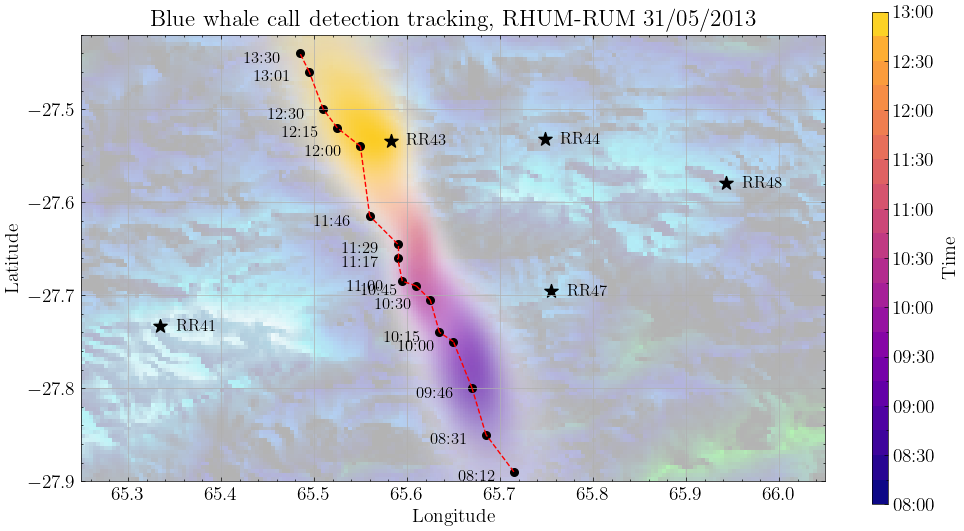

In [82]:
from matplotlib.colors import Normalize, ListedColormap, BoundaryNorm
from matplotlib.cm import get_cmap, ScalarMappable
import scienceplots
from matplotlib.colors import LightSource
import xarray as xr
# set fontsize
plt.rcParams.update({'font.size': 14})

with plt.style.context('science'):

    bathymetry_file = "/data/UPFLOW/projects/iReverb/reverb/examples/download/gebco_2024_n-27.0_s-30.0_w65.0_e67.0.nc"  # Replace with your file path
    bathymetry_data = xr.open_dataset(bathymetry_file)

    # Extract relevant variables
    # Adjust 'lon' and 'lat' as per your dataset's variable names
    lon = bathymetry_data['lon']
    lat = bathymetry_data['lat']
    elevation = bathymetry_data['elevation']

    # Select region of interest (based on your grid's extent)
    lon_min, lon_max = grid_x.min(), grid_x.max()
    lat_min, lat_max = grid_y.min(), grid_y.max()
    roi = elevation.sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max))

    # Create a light source for shading
    light_source = LightSource(azdeg=315, altdeg=45)
    shaded_bathymetry = light_source.shade(
        roi.values,
        cmap=get_cmap('ocean_r'),
        vmin=-6500, vmax=-2000,

        vert_exag=1,
        # blend_mode='soft',
)

    def create_fade_colormap_to_white(base_colour, N):
        """Create a colormap that fades from the given colour towards white and becomes transparent."""
        base_colour = np.array(base_colour)  # Ensure it's a NumPy array
        colours = np.zeros((256, 4))  # 256 steps, RGBA
        fade_scale = np.clip(1 - (N / 5), 0, 1) 
        for i in range(256):
            fade_factor = (i / 255.0) ** (1 + fade_scale * 2) 
            alpha = fade_factor  
            colours[i, :3] = np.clip((base_colour[:3] * (fade_factor) + np.array([1, 1, 1]) * (1-fade_factor)), 0, 1)   # RGB towards white
            colours[i, 3] = 0.8*alpha  # Alpha increases linearly
        return plt.cm.colors.ListedColormap(colours)
    # Prepare figure
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.imshow(
        shaded_bathymetry,
        extent=(lon_min, lon_max, lat_min, lat_max),
        origin='lower',
        interpolation='nearest',
        alpha=0.3  # Adjust transparency
    )
    timestamps = [res[0] for res in rolling_results]
    time_norm = Normalize(vmin=min(timestamps).timestamp(), vmax=max(timestamps).timestamp())
    colour_map = get_cmap('plasma')
    colors_used = []
    timestamps_used = []
    # Loop through each rolling result
    for hour, rolling_misfits, N in rolling_results:
        # Normalise misfits for alpha transparency
        # rolling_misfits  = rolling_misfits / np.max(rolling_misfits)
        if N < 10:
            continue
        normalised_misfits = (rolling_misfits - rolling_misfits.min()) / (rolling_misfits.max() - rolling_misfits.min() + 1e-8)
        # Map time to a colour
        colour = colour_map(time_norm(hour.timestamp()))
        fade_colormap = create_fade_colormap_to_white(colour, N)
        colors_used.append(colour)
        timestamps_used.append(hour)
        ax.imshow(
            normalised_misfits,
            cmap=fade_colormap,
            extent=(grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max()),
            origin='lower',
            interpolation='nearest'
        )
    for station, _ in station_coords.items():
        if station in ['RR42', 'RR45', 'RR46']:
            continue
        x, y = station_coords[station]
        ax.scatter(x, y, marker='*', color='black',s =100)
        ax.text(x+ 0.06, y-0.005, station, fontsize=12, ha='right')
    # Final plot adjustments
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title('Blue whale call detection tracking, RHUM-RUM 31/05/2013')
    custom_colormap = ListedColormap(colors_used)
    time_indices = range(len(colors_used))  # Sequential indices for each timestamp
    norm = BoundaryNorm(time_indices, custom_colormap.N )
    time_labels = [t.strftime('%H:%M') for t in timestamps_used]  # Format datetimes as %H:%M

    sm = ScalarMappable(norm=norm, cmap=custom_colormap)
    sm.set_array([])  # ScalarMappable needs an array, even if it's empty
    cbar = plt.colorbar(sm, ax=ax, label='Time', shrink=0.8, aspect=30)
    cbar.set_ticks(time_indices[::2])  # Set ticks to indices
    cbar.set_ticklabels(time_labels[::2])  #
    # gridlines

    for time, (lat, lon) in whale_track:
        ax.scatter(lon, lat, marker='o', color='black', s=30)
        ax.text(lon - 0.02, lat- 0.01, time, fontsize=12, ha='right')
    # connect the dots
    latlons = [(lat,long) for _, (lat, long) in whale_track]
    for i in range(len(latlons)-1):
        (lat1, lon1), (lat2, lon2) = latlons[i:i+2]
        ax.plot([lon1, lon2], [lat1, lat2], color='red', linestyle='--')
    ax.grid(True)
    plt.savefig('whale_call_detection_tracking.png', dpi=200, transparent=True)
    plt.show()

In [73]:
whale_track = [
    ("08:12", (-27.89, 65.715)),
    ("08:31", (-27.85, 65.685)),
    ("09:46", (-27.80, 65.67)),
    ("10:00", (-27.75, 65.65)),
    ("10:15", (-27.74, 65.635)),
    ("10:30", (-27.705, 65.625)),
    ("10:45", (-27.69, 65.61)),
    ("11:00", (-27.685, 65.595)),
    ("11:17", (-27.66, 65.59)),
    ("11:29", (-27.645, 65.59)),
    ("11:46", (-27.615, 65.56)),
    ("12:00", (-27.54, 65.55)),
    ("12:15", (-27.52, 65.525)),
    ("12:30", (-27.5, 65.51)),
    ("13:01", (-27.46, 65.495)),
    ("13:30", (-27.44, 65.485))
]
